In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.sparse import csc_matrix, linalg as sla
from scipy.optimize import root

In [10]:
R1 = 1
R2 = 8
r = np.linspace(R1, R2, 1000)
dr = (np.max(r)-np.min(r))/(len(r)-1)


In [29]:
#Poisson Solver
@njit(parallel=True)
def M(r, dr):
    col = np.zeros(3*len(r)-4)
    row = np.zeros(3*len(r)-4)
    data = np.zeros(3*len(r)-4)
    data[0] = 1
    for i in range(1, len(r)-1):
        row[3*i-1:3*i+2] = i
        col[3*i-1] = i-1
        col[3*i] = i
        col[3*i+1] = i+1
        data[3*i-1] = (r[i]-dr/2)/(dr**2*r[i])
        data[3*i] = -2/dr**2
        data[3*i+1] = (r[i]+dr/2)/(dr**2*r[i])
    row[-1] = len(r)-1
    col[-1] = len(r)-1
    data[-1] = len(r)-1
    return data, col, row

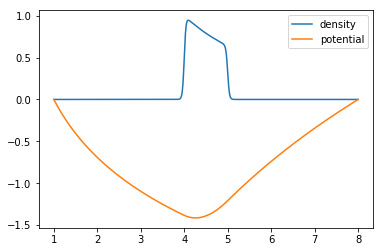

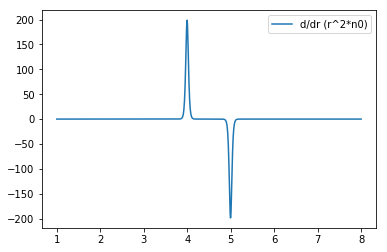

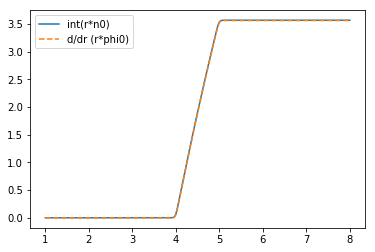

In [32]:
data, col, row = M(r, dr)
A = csc_matrix((data, (row, col)), shape=(len(r), len(r)))
lu = sla.splu(A)

n0 = (8/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
n0[0] = 0
n0[-1] = 0
phi = lu.solve(n0)

plt.plot(r, n0, label='density')
plt.plot(r, phi, label='potential')
plt.legend()
plt.show()

dn0 = np.zeros(len(r))
in0 = np.zeros(len(r))
dphi = np.zeros(len(r))

for i in range(len(r)-1):
    dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
    in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dphi[i] = r[i]*(phi[i+1]-phi[i])/dr
dn0[-1] = 2*dn0[-2] - dn0[-3]
in0[-1] = 2*in0[-2] - in0[-3]
dphi[-1] = 2*dphi[-2] - dphi[-3]
dphi = dphi - dphi[0]

plt.plot(r, dn0, label='d/dr (r^2*n0)')
plt.legend()
plt.show()

plt.plot(r, in0, label='int(r*n0)')
plt.plot(r, dphi, label='d/dr (r*phi0)', linestyle='dashed')
plt.legend()
plt.show()

In [54]:
#Poisson Solver
@njit(parallel=True)
def Mr(s, ds, h, dn0_r, in0_r, dn0_i, in0_i, o_r, o_i):
    col = np.zeros(3*len(s)-2)
    row = np.zeros(3*len(s)-2)
    data = np.zeros(3*len(s)-2)
    data[0] = 1
    col[1] = 1
    row[1] = 1
    data[1] = 1
    for i in prange(2, len(s)):
        row[3*i-4:3*i-1] = i
        col[3*i-4] = i-2
        col[3*i-3] = i-1
        col[3*i-2] = i
        dh = h[i]-h[i-1]
        der1 = (s[i]*ds-h[i]*dh)/(((s[i]**2 + h[i]**2)*(ds**2+dh**2)))
        dh1 = h[i-1]-h[i-2]
        dh2 = dh+dh1
        der_inv = (ds**2+dh**2)*(4*ds**2+dh2**2)
        der_inv1 = (ds**2+dh1**2)*(4*ds**2+dh2**2)
        der2 = 2*(2*ds**2 - dh*dh2)
        der21 = 2*(2*ds**2 - dh1*dh2)
        sr = s[i]*(in0_r[i]-o_r)
        si = s[i]*(in0_i[i]-o_i)
        hr = h[i]*(in0_r[i]-o_r)
        hi = -h[i]*(in0_i[i]-o_i)
        dia_inv = (sr+hi)**2 + (si+hr)**2
        dia = dn0_r[i]*(sr+hi) + dn0_i[i]*(si+hr)
        data[3*i-4] = der21/der_inv1
        data[3*i-3] = -1-der1-der2/der_inv-der21/der_inv1+dia/dia_inv
        data[3*i-2] = der1+der2/der_inv
    return data, col, row

In [55]:
#Poisson Solver
@njit(parallel=True)
def Mi(s, ds, h, dn0_r, in0_r, dn0_i, in0_i, o_r, o_i):
    col = np.zeros(3*len(s)-2)
    row = np.zeros(3*len(s)-2)
    data = np.zeros(3*len(s)-2)
    data[0] = 1
    col[1] = 1
    row[1] = 1
    data[1] = 1
    for i in prange(2, len(s)):
        row[3*i-4:3*i-1] = i
        col[3*i-4] = i-2
        col[3*i-3] = i-1
        col[3*i-2] = i
        dh = h[i]-h[i-1]
        der1 = -(h[i]*ds-s[i]*dh)/(((s[i]**2 + h[i]**2)*(ds**2+dh**2)))
        dh1 = h[i-1]-h[i-2]
        dh2 = dh+dh1
        der_inv = (ds**2+dh**2)*(4*ds**2+dh2**2)
        der_inv1 = (ds**2+dh1**2)*(4*ds**2+dh2**2)
        der2 = -2*ds*(2*dh+dh2)
        der21 = -2*ds*(2*dh1+dh2)
        sr = s[i]*(in0_r[i]-o_r)
        si = s[i]*(in0_i[i]-o_i)
        hr = h[i]*(in0_r[i]-o_r)
        hi = -h[i]*(in0_i[i]-o_i)
        dia_inv = (sr+hi)**2 + (si+hr)**2
        dia = -dn0_r[i]*(si+hr) + dn0_i[i]*(sr+hi)
        data[3*i-4] = der21/der_inv1
        data[3*i-3] = -1-der1-der2/der_inv-der21/der_inv1+dia/dia_inv
        data[3*i-2] = der1+der2/der_inv
    return data, col, row

In [56]:
def shooting(s, ds, h, dn0_r, in0_r, dn0_i, in0_i, omega):
    def fun(omega):
        data, col, row = Mi(s, ds, h, dn0_r, in0_r, dn0_i, in0_i, omega[0], omega[1])
        Ai = csc_matrix((data, (row, col)), shape=(len(s), len(s)))
        data, col, row = Mr(s, ds, h, dn0_r, in0_r, dn0_i, in0_i, omega[0], omega[1])
        Ar = csc_matrix((data, (row, col)), shape=(len(s), len(s)))
        fr = np.zeros(len(s))
        fr[1] = 1
        fi = np.zeros(len(s))
        fi[1] = 1
        phi_i = sla.spsolve(Ai, fi)
        phi_r = sla.spsolve(Ar, fr)
        return phi_r[-1], phi_i[-1]
    Root = root(fun, omega)
    return(Root)

0 [0.2673064 0.5669227]


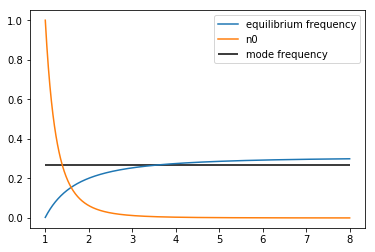

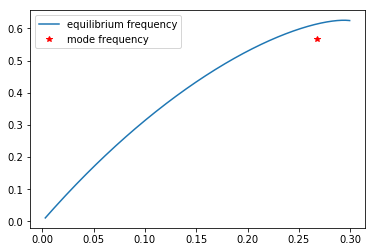

-5.335113054989189e-13 -1.056780819908605e-08
8.71182204794514e-12 -1.965788782556238e-08


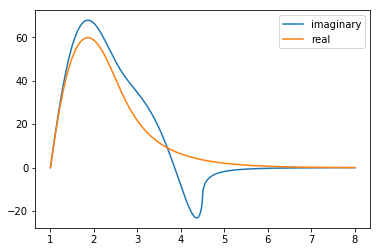

In [67]:
for j in range(1):
    s0 = (j+10)*(R1+R2)/10
    h0 = 1
    w = (R2-R1)/2

    s = np.linspace(R1, R2, 1000)
    ds = (np.max(s)-np.min(s))/(len(s)-1)
    h = (s-R1)*(R2-s)
    #h = np.exp(-((s-s0)/w)**2)*(s-R1)*(R2-s)
    h = h0*h/np.max(h)+1
    dn0_i = np.zeros(len(s))
    dn0_r = np.zeros(len(s))
    in0_i = np.zeros(len(s))
    in0_r = np.zeros(len(s))
    for i in range(len(s)-1):
        dh = h[i+1]-h[i]
        c_i = (-dh*(s[i]**2-h[i]**2)+2*ds*h[i]*s[i])/(ds**2+dh**2)
        c_r = (ds*(s[i]**2-h[i]**2)+2*dh*h[i]*s[i])/(ds**2+dh**2)
        dn0_i[i] = (2*h[i]-c_i)*n0[i] + c_i*n0[i+1]
        dn0_r[i] = (2*s[i]-c_r)*n0[i] + c_r*n0[i+1]
        d_i0 = dh*s[i]+ds*h[i]
        d_i1 = dh*s[i+1]+ds*h[i+1]
        d_r0 = ds*s[i]-dh*h[i]
        d_r1 = ds*s[i+1]-dh*h[i+1]
        in0_i[i] = in0_i[i-1] + (n0[i+1]*d_i1 + n0[i]*d_i0)/2
        in0_r[i] = in0_r[i-1] + (n0[i+1]*d_r1 + n0[i]*d_r0)/2
    dn0_i[-1] = 2*dn0_i[-2] - dn0_i[-3]
    dn0_r[-1] = 2*dn0_r[-2] - dn0_r[-3]
    in0_i[-1] = 2*in0_i[-2] - in0_i[-3]
    in0_r[-1] = 2*in0_r[-2] - in0_r[-3]

    omega = [0.5, 0.5]
    omega = shooting(s, ds, h, dn0_r, in0_r, dn0_i, in0_i, omega).x
    print(j, omega)
    plt.plot(s, in0_r, label='equilibrium frequency')
    plt.hlines(omega[0], R1, R2, label='mode frequency')
    #plt.plot(s, in0_i, label='imaginary branch')
    plt.plot(s, n0, label='n0')
    #plt.hlines(omega[1], R1, R2, label='imaginary mode')
    plt.legend()
    plt.show()

    plt.plot(in0_r, in0_i, label='equilibrium frequency')
    plt.plot(omega[0], omega[1], "r*", label='mode frequency')
    plt.legend()
    plt.show()
    data, col, row = Mi(s, ds, h, dn0_r, in0_r, dn0_i, in0_i, omega[0], omega[1])
    Ai = csc_matrix((data, (row, col)), shape=(len(s), len(s)))
    #Ai_array = Ai.toarray()
    data, col, row = Mr(s, ds, h, dn0_r, in0_r, dn0_i, in0_i, omega[0], omega[1])
    Ar = csc_matrix((data, (row, col)), shape=(len(s), len(s)))
    fr = np.zeros(len(s))
    fi = np.zeros(len(s))
    fi[1] = 1
    fr[1] = 1
    phi_i = sla.spsolve(Ai, fi)
    phi_r = sla.spsolve(Ar, fr)
    print(phi_r[0], phi_r[-1])
    print(phi_i[0], phi_i[-1])
    #plt.plot(s, h)
    #plt.show()
    plt.plot(s, phi_i, label='imaginary')
    plt.plot(s, phi_r, label='real')
    plt.legend()
    plt.show()

In [72]:
print(n0[np.argmin(abs(in0_r-omega[0]))])

0.006292412701320704


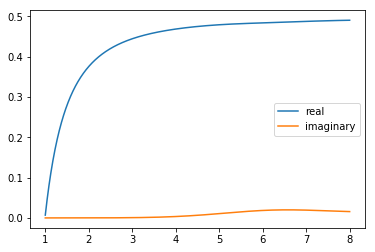

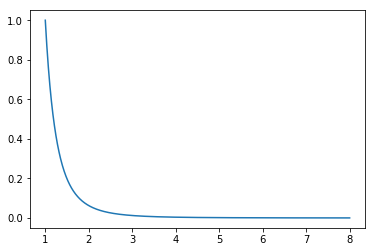

7.46046046046046 1.0


In [59]:
plt.plot(s, in0_r, label='real')
plt.plot(s, in0_i, label='imaginary')
plt.legend()
plt.show()
plt.plot(s, n0)
plt.show()
print(s[np.argmax(phi_r)], s[np.argmax(n0)])